In [246]:
import importlib
import data_transform
import Cross_validation
importlib.reload(data_transform)
importlib.reload(Cross_validation)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Visualization.Feature_importance import FeatImp
from data_transform import apply_transformations,detect_outliers
from Cross_validation import cross_validation,BlockingTimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

#Models for predicting
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor,VotingRegressor
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

#Grid Search
from sklearn.model_selection import GridSearchCV

# preparing and cleaning data
data = pd.read_csv('data/avocado.csv')
data = data.sort_values(by=['Date'])
dates = data['Date']
target = data['AveragePrice']

data = data.drop(['Unnamed: 0','AveragePrice'],axis = 1)

# applied all transformations
data_2 = apply_transformations(data)
outliers = detect_outliers(data_2,6,data_2.columns.values)
data_2 = data_2.drop(outliers, axis = 0).reset_index(drop=True)
# seperating into train, test
train_size_start = int(0.4*len(data_2))
train_size_end = int(0.8*len(data_2))
test_size_end = int(1*len(data_2))
#train data
X_train = data_2[:][train_size_start:train_size_end]
y_train = target[train_size_start:train_size_end]

# test data
X_test = data_2[:][train_size_end:test_size_end]
y_test = target[train_size_end:test_size_end]
dates = dates[train_size_end:test_size_end]

In [247]:
#scaling data

SC = StandardScaler()
X_train = SC.fit_transform(X_train) # important to fit data to X_train and applying same statistical properties to X_test!!!
X_test = SC.transform(X_test)

y_train = pd.Series(SC.fit_transform(np.array(y_train).reshape(-1,1)).ravel()) # same goes for target values!!!
y_test = pd.Series(SC.transform(np.array(y_test).reshape(-1,1)).ravel())
X_train

array([[ 0.64799143,  0.92224691,  0.49365069, ..., -0.28263343,
        -0.25079954, -0.25079954],
       [ 1.04627591,  1.24032714,  0.72648667, ..., -0.28263343,
        -0.25079954, -0.25079954],
       [ 0.45251974,  0.40698469,  0.5328853 , ..., -0.28263343,
        -0.25079954, -0.25079954],
       ...,
       [-0.53982172,  0.02518606, -0.59451676, ..., -0.28263343,
        -0.25079954, -0.25079954],
       [-0.09544362,  0.45084418, -0.58220553, ..., -0.28263343,
        -0.25079954, -0.25079954],
       [-0.80097849, -0.39409152, -0.51550432, ..., -0.28263343,
        -0.25079954, -0.25079954]])

In [250]:
cross_validation(X_train,y_train)

,SVR,Random Forest Regressor,Extra Trees Regressor,AdaBoost,LinearRegresion,SGD
means,0.577678,0.592815,0.617329,0.602639,-1.373630e+25,0.592494
std,0.155144,0.059458,0.085560,0.074670,1.787419e+25,0.083775


[0.7922791441366619,
 0.8191692446682449,
 0.8438948597779066,
 0.8253752522485431,
 -5.952385104040235e+21,
 0.5479946591465854]

In [113]:
# Random Forest Regressor hyperparameter Tuning

RFR = RandomForestRegressor()
btss = BlockingTimeSeriesSplit(n_splits=5)

rfr_params = {"n_estimators":[100,200],
              "criterion":['mse'],
              "max_depth":[6,8,10,20],
             }
gsRFC = GridSearchCV(RFR,param_grid = rfr_params, cv=btss, scoring="r2", n_jobs= -1, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   22.8s finished


In [59]:
gsRFC.best_params_

{'criterion': 'mse', 'max_depth': 20, 'n_estimators': 100}

In [114]:
# Extra Trees Regressor hyperparameter Tuning

ETR = ExtraTreesRegressor()
btss = BlockingTimeSeriesSplit(n_splits=5)

ETR_params = {"n_estimators":[100,200],
              "criterion":['mse'],
              "max_depth":[6,8,10,20],
             }
gsETR = GridSearchCV(ETR,param_grid = ETR_params, cv=btss, scoring="r2", n_jobs= -1, verbose = 1)

gsETR.fit(X_train,y_train)

ETR_best = gsETR.best_estimator_


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   21.8s finished


In [61]:
ETR_best

ExtraTreesRegressor(max_depth=20, n_estimators=200)

In [62]:
gsETR.best_params_

{'criterion': 'mse', 'max_depth': 20, 'n_estimators': 200}

In [115]:
AB = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

AB_params = {"n_estimators":[10,50,100,200],
              "learning_rate":[0.1,0.5,1,2],
              "loss":["linear","square","exponential"],
             }
gsAB = GridSearchCV(AB,param_grid = AB_params, cv=btss, scoring="r2", n_jobs= -1, verbose = 1)

gsAB.fit(X_train,y_train)

AB_best = gsAB.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.5min finished


In [66]:
gsAB.best_params_
AB_best

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), learning_rate=0.1,
                  loss='exponential', n_estimators=100)

In [116]:
svr = SVR()
svr_params = {"kernel":['linear','poly','rbf','sigmoid'],
              "gamma":['scale','auto'],
              "C":[2,3,4]}

gsSVR = GridSearchCV(svr,param_grid = svr_params, cv=btss, scoring="r2", n_jobs= -1, verbose = 1)

gsSVR.fit(X_train,y_train)

svr_best = gsSVR.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   21.2s finished


In [68]:
gsSVR.best_params_

{'C': 4, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

In [251]:
votingR = VotingRegressor(estimators=[('rfc', RFC_best),
('ETR', ETR_best),('AB',AB_best),('svr',svr_best)],  n_jobs=-1)

votingC = votingR.fit(X_train, y_train)

0.4693124632769139


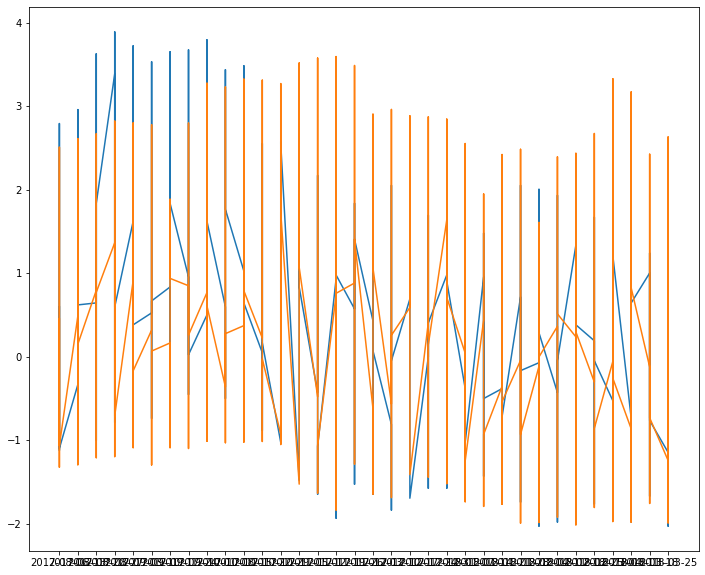

In [252]:
from sklearn.metrics import r2_score
predict = votingC.predict(X_test)
predict = pd.DataFrame(predict)
y_test= y_test.reset_index().drop(["index"],axis=1)
results = pd.concat([predict,y_test],axis = 1)
print(r2_score(y_test,predict))
plt.figure(figsize=(12,10))
plt.plot(dates,y_test)
plt.plot(dates,predict)


In [ ]:
'''I get poor results with my models. My best guess is that i should not have applied my log-transform or not have done OneHot
Encoding for months and year features, to fix my model.

In [144]:
results

,0,AveragePrice
0,1.653596,1.66
1,1.718801,1.65
2,1.551873,1.63
3,1.462628,1.47
4,1.735848,1.74
...,...,...
3645,1.526821,1.36
3646,1.029981,0.70
3647,1.523834,1.42
3648,1.806990,1.70


In [ ]:
'''The best results I get with my hypertuned models is 0.47 r2 score, which is approximately 0.3 worse than what my cross-validation
returned. What could be the reason for such bad performance? Since my data was ordered like a Time-Series I assume that Models I used
had learned patterns in the training data and predicted the same behaviour for the test set. But since Time series data is highly volatile
, said patterns did not apply to the test set. In my experimentation with the training data I noticed that my models perform best if I 
reduce the training size and teach only on data that is closer to the test set. Another reason for bad results could be that I used too many
features. Maybe I should've used less features or seperated data into smaller chunks, for example I could seperate data into regions, and
predict for each region.
'''